# Determining constants for the Leishman--Beddoes dynamic stall model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt, sum
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
# Function for loading data
def load(foil="NACA0021", xfoil=False, csv=False):
    if csv:
        fpath = "data/{}_3.6e5_Sheldahl.csv".format(foil)
        df = pd.read_csv(fpath)
    else:
        if xfoil:
            fpath = "data/{}_XFOIL.txt".format(foil)
        else:
            fpath = "data/{}.dat".format(foil)
        alpha = []
        cl = []
        cd = []
        cm = []
        with open(fpath) as f:
            for line in f.readlines():
                if line.strip()[:2] == "//":
                    pass
                else:
                    line = line.replace("(", "")
                    line = line.replace(")", "")
                    line = line.split()
                    alpha.append(float(line[0]))
                    cl.append(float(line[1]))
                    cd.append(float(line[2]))
                    try:
                        cm.append(float(line[4]))
                    except IndexError:
                        cm.append(np.nan)
        df = pd.DataFrame()
        df["alpha_deg"] = np.asarray(alpha)
        df["cl"] = np.asarray(cl)
        df["cd"] = np.asarray(cd)
        df["cm"] = np.asarray(cm)
    df["alpha_rad"] = df.alpha_deg/180.0*np.pi
    df["cn"] = df.cl*np.cos(df.alpha_rad) - df.cd*np.sin(df.alpha_rad)
    df["ct"] = df.cl*np.sin(df.alpha_rad) - df.cd*np.cos(df.alpha_rad)
    return df

We want to find the constants $S_1$ and $S_2$ that relate the Kirchhoff separation point $f$ to the normal force coefficient.

$$
C_N = C_{N_\alpha} \left( \frac{1 + \sqrt{f}}{2} \right)^2 (\alpha - \alpha_0)
$$

Rearranging we have

$$
f = \left(2\sqrt{\frac{C_N}{(\alpha - \alpha_0) C_{N_\alpha}}} - 1\right)^2
$$

The separation point is then

$$
f = 1 - 0.3 \exp \left[ (\alpha - \alpha_1)/S_1 \right]
$$

for $\alpha \leq \alpha_1$, and for $\alpha > \alpha_1$

$$
f = 0.04 + 0.66 \exp \left[ (\alpha_1 - \alpha)/S_2 \right].
$$

alpha_ss = 14.0
alpha1 = 12.6
alpha0 = -0.237036380346
cn_alpha = 5.28023016473
s1 = 0.09058799558674582
s2 = 0.04870461592124952


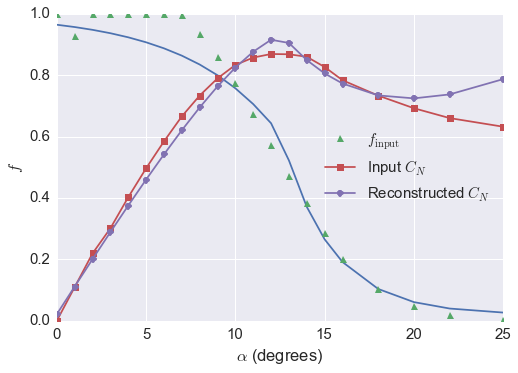

In [156]:
def find_alpha_ss(df, threshold=0.03):
    """Find static stall angle in degrees."""
    d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
    n = np.where(d_cd_d_alpha > threshold)[0]
    alpha_ss = df.alpha_deg.iloc[n]
    alpha_ss = alpha_ss.iloc[0]
    return alpha_ss

    
def calc_cn_alpha(df, frac_cn_alpha=0.75):
    """Calculate normal force slope."""
    alpha_ss = find_alpha_ss(df)
    df = df[df.alpha_deg <= alpha_ss*frac_cn_alpha]
    x = df.alpha_rad
    y = df.cn
    A = np.array([[len(x), sum(x)],
                  [sum(x), sum(x**2)]])
    b = np.array([sum(y), sum(x*y)])
    cn0, cn_alpha = np.linalg.solve(A, b)
    alpha0 = -cn0/cn_alpha
    return cn_alpha, alpha0


def calc_alpha1(df, frac_alpha1=0.95):
    """Calculate the separation breaking point in radians."""
    return np.deg2rad(frac_alpha1*find_alpha_ss(df))


def calc_s1_s2(df, A=1.0, B=0.4, C=0.02, D=0.58, frac_cn_alpha=0.75, frac_alpha1=0.95):
    """Calculate S_1 and S_2 coefficients using a least squares regression."""
    df_all = df[df.alpha_deg >= 0]
    df_all = df_all[df_all.alpha_deg <= 20]
    cn_alpha, alpha0 = calc_cn_alpha(df, frac_cn_alpha)
    alpha1 = calc_alpha1(df, frac_alpha1)
    df = df_all[df_all.alpha_rad <= alpha1]
    alpha = df.alpha_rad
    f = cn2f(df.cn, alpha, cn_alpha, alpha0=alpha0, limit=True)
    x = alpha - alpha1
    y = (f - A)/(-B)
    try:
        b = np.sum(x*y*log(y))/sum(x*x*y)
    except ZeroDivisionError:
        b = np.nan
    s1 = 1/b
    f_low = A - B*np.exp((alpha - alpha1)/s1)
    # Now S_2
    df = df_all[df_all.alpha_rad > alpha1]
    alpha = df.alpha_rad
    f = cn2f(df.cn, alpha, cn_alpha, alpha0=alpha0)
    x = alpha1 - alpha
    y = (f - C)/(D)
    try:
        b = np.sum(x*y*log(y))/sum(x*x*y)
    except ZeroDivisionError:
        b = np.nan
    s2 = 1/b
    return s1, s2


def cn2f(cn, alpha_rad, cn_alpha, alpha0=0.0, limit=False):
    """Convert normal force coefficient to trailing edge separation point."""
    f = pow((sqrt(abs(cn)/cn_alpha/abs((alpha_rad - alpha0)))*2.0 - 1.0), 2)
    if limit:
        f[f > 1] = 1.0
        f[f < 0] = 0.0
    return f


def f2cn(f, alpha_rad, cn_alpha, alpha0=0.0):
    """Convert trailing edge separation point to normal force coefficient."""
    return cn_alpha*(alpha_rad - alpha0)*((1 + np.sqrt(f))/2)**2


def calc_reconst(foil="NACA0021", A=1.0, B=0.4, C=0.02, D=0.58, frac_cn_alpha=0.6, 
                 frac_alpha1=0.9):
    """
    Calculate reconstructed force coefficients and return along with input data.
    
    A, B, C, D = 1.0, 0.3, 0.04, 0.66 for the original model
    """
    if foil == "0021":
        df = load(foil=foil, csv=True)
    else:
        df = load(foil=foil)
    df = df[df.alpha_deg >= 0]
    df = df[df.alpha_deg <= 25]
    cn_alpha, alpha0 = calc_cn_alpha(df, frac_cn_alpha=frac_cn_alpha)
    alpha1 = calc_alpha1(df, frac_alpha1=frac_alpha1)
    s1, s2 = calc_s1_s2(df, A=A, B=B, C=C, D=D, frac_cn_alpha=frac_cn_alpha, 
                        frac_alpha1=frac_alpha1)
    f = []
    for alpha in df.alpha_rad:
        if alpha <= alpha1:
            f.append(A - B*np.exp((alpha - alpha1)/s1))
        elif alpha > alpha1:
            f.append(C + D*np.exp((alpha1 - alpha)/s2))
    df["f"] = f
    df["cn_reconst"] = f2cn(f, df.alpha_rad, cn_alpha, alpha0=alpha0)
    df["f_in"] = cn2f(df.cn, df.alpha_rad, cn_alpha, alpha0=alpha0, limit=True)
    print("alpha_ss =", np.rad2deg(alpha1/frac_alpha1))
    print("alpha1 =", np.rad2deg(alpha1))
    print("alpha0 =", np.rad2deg(alpha0))
    print("cn_alpha =", cn_alpha)
    print("s1 =", s1)
    print("s2 =", s2)
    return df
    

# foil = "S826_Ostavan"
foil = "NACA0021"
# foil = "NACA0012"
df = calc_reconst(foil=foil, frac_cn_alpha=0.6, frac_alpha1=0.9)

plt.plot(df.alpha_deg, df.f)
plt.plot(df.alpha_deg, df.f_in, "^", label="$f_\mathrm{input}$")
plt.plot(df.alpha_deg, df.cn, "-s", label=r"Input $C_N$")
plt.plot(df.alpha_deg, df.cn_reconst, "-o", label=r"Reconstructed $C_N$")
# plt.ylim((None, 1.4))
plt.xlabel(r"$\alpha$ (degrees)")
plt.ylabel("$f$")
plt.legend(loc="best")
plt.show()

## Relating $f$ to $C_m$

From Leishman and Beddoes (1989):

$$
\frac{C_m}{C_n} = K_0 + K_1(1-f) + K_2 \sin (\pi f^m),
$$

Where $K_0 = (0.25 - x_{ac})$, $m$ can be 1/2, 1, or 2 depending on which fits the curve best. Note that $m$ is just a coefficient, and is not related to the moment.


### Least squares fitting

$$
S = \sum_{f_i} \left( y(f) - C_m/C_n \right)^2
$$

$$
S = \sum_{f_i} \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right)^2
$$

$$
\frac{\partial S}{\partial K_1} 
= 2 \sum_{f_i} \left[ \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right) (1-f) \right]
$$

$$
\frac{\partial S}{\partial K_2} 
= 2 \sum_{f_i} \left[ \left( K_0 + K_1(1-f) + K_2 \sin (\pi f^m) - C_m/C_n \right) (\sin (\pi f^m)) \right]
$$

Rearrange into the form:

$$
Ax = b
$$

$$
\begin{bmatrix}
    A_{11} & A_{12} \\
    A_{21} & A_{22}
\end{bmatrix}
\begin{bmatrix}
    K_1 \\
    K_2
\end{bmatrix}
= \begin{bmatrix}
    F_{11} (C_m/C_n) \\
    F_{21} (C_m/C_n)
\end{bmatrix}
$$

$$
\begin{bmatrix}
    \sum (1-f)^2 & \sum \sin(\pi f^m)(1-f) \\
    \sum \sin(\pi f^m)(1-f) & \sum \sin^2 (\pi f^m)
\end{bmatrix}
\begin{bmatrix}
    K_1 \\
    K_2
\end{bmatrix}
= \begin{bmatrix}
    \sum C_m/C_n (1-f) - K_0 \sum (1-f) \\
    \sum C_m/C_n \sin(\pi f^m) - K_0 \sum \sin (\pi f^m)
\end{bmatrix}
$$


### Useful example on least squares fitting in OpenFOAM

https://openfoamwiki.net/index.php/Howto_simpleMatrixLeastSquareFit

k1 = -0.0872354927912
k2 = 0.0578128810593


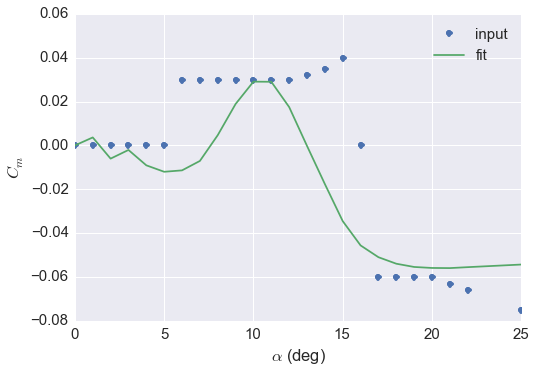

In [119]:
def fit_cm(df, k0=0.001, m=1, frac_cn_alpha=0.6):
    """Fit moment coefficient."""
    cn_alpha, alpha0 = calc_cn_alpha(df, frac_cn_alpha=frac_cn_alpha)
    f = cn2f(df.cn, df.alpha_rad, cn_alpha, alpha0=alpha0, limit=False)
    cm, cn = df.cm, df.cn
    A = np.array([[sum((1 - f)**2), sum(sin(pi*f**m))],
                  [sum(sin(pi*f**m)*(1 - f)), sum((sin(pi*f**m))**2)]])
    b = np.array([sum(cm/cn*(1 - f)) - k0*sum(1 - f),
                  sum(cm/cn*sin(pi*f**m)) - k0*sum(sin(pi*f**m))])
    k1, k2 = np.linalg.solve(A, b)
    cm_fit = (k0 + k1*(1 - f) + k2*sin(pi*f**m))*cn
    return k1, k2, cm_fit


df = load(foil="NACA0021", csv=True)
df = df[df.alpha_deg <= 25]
k1, k2, cm_fit = fit_cm(df, m=2, frac_cn_alpha=0.7)
print("k1 =", k1)
print("k2 =", k2)
plt.plot(df.alpha_deg, df.cm, "o", label="input")
plt.plot(df.alpha_deg, cm_fit, label="fit")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel("$C_m$")
plt.legend(loc="best")
plt.show()